In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.regressionplots import influence_plot

In [4]:
df = pd.read_csv("data/processed_data/diabetes.csv")
print(df.head())

   Pregnancies  Glucose  BloodPressure  ...  DiabetesPedigreeFunction  Age  Outcome
0            6    148.0           72.0  ...                     0.627   50        1
1            1     85.0           66.0  ...                     0.351   31        0
2            8    183.0           64.0  ...                     0.672   32        1
3            1     89.0           66.0  ...                     0.167   21        0
4            0    137.0           40.0  ...                     2.288   33        1

[5 rows x 9 columns]


In [5]:
#Scaling features for the mulicollinearity test
X = df.drop(columns = "Outcome")
y = df['Outcome']
X_scaled = StandardScaler().fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

In [6]:
#VIF test
vif_data = pd.DataFrame()
vif_data['features']=X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
print(vif_data)

                   features       VIF
0               Pregnancies  1.429998
1                   Glucose  1.353074
2             BloodPressure  1.239114
3             SkinThickness  1.451069
4                   Insulin  1.231335
5                       BMI  1.567784
6  DiabetesPedigreeFunction  1.045751
7                       Age  1.618502


Since the Varaince Inflation Factor are less than 5, there are no much collinearity between the independent variables. Thus the proposed model passes the multicollinearity test.

In [7]:
#Stratified split of the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [25]:
param_grid = {
    'model__C' : [0.01, 0.1, 1, 10, 100],
    'model__penalty' : ['l1','l2'],
    'model__solver' : ['liblinear'],
    'model__class_weight' : ['balanced']
}

In [26]:
grid_search = GridSearchCV(pipeline, param_grid, cv= 5, scoring = 'f1', verbose= 1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__class_weight': ['balanced'],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear']},
             scoring='f1', verbose=1)

In [43]:
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best parameters: {'model__C': 1, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best F1 score: 0.6731263928827216


The F1 score shows that the model is catching positive rates resasonably well without compromising much on the precision.

In [27]:
best_model = grid_search.best_estimator_

In [46]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154

[[75 25]
 [16 38]]


The model has a positive recall of 0.70 (i.e) correctly identifies 70% of the actual diabetes and an accuracy of 77%.

In [37]:
probs = best_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)


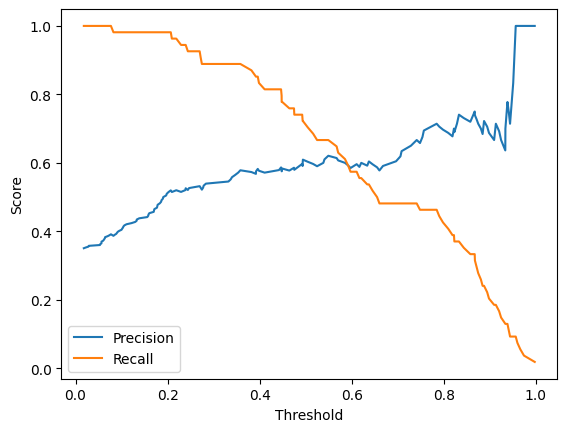

In [36]:
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

Since the false negatives are very bad for the model, we can reduce the threshold to a value lower than the 0.5(default) so we can have better diagnosis. As we lower the threshold the recall value increases and we can mitigate the false negatives in our model.

In [40]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC:", roc_auc)

ROC AUC: 0.8112962962962963


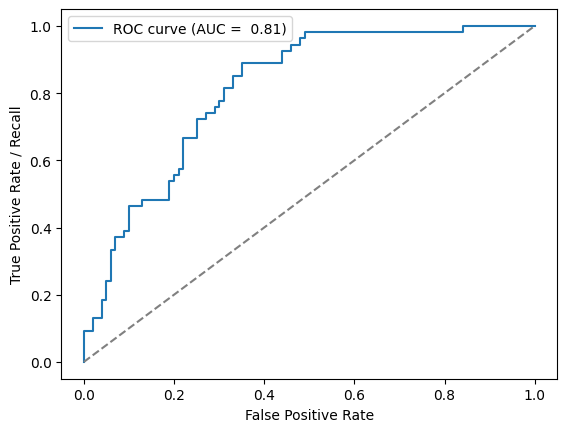

In [42]:
plt.plot(false_positive_rate, true_positive_rate, label = f'ROC curve (AUC = {roc_auc: .2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Recall')
plt.legend()
plt.show()

In [ ]:
#Linearty test - Box-Tidwall test
X2 = X.copy()
for col in X.columns:
    X2[f'{col}_log'] = X[col] * np.log(X[col] + 1e-5)

X2 = sm.add_constant(X2)
logit_model = sm.Logit(y, X2).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.437464
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      751
Method:                           MLE   Df Model:                           16
Date:                Fri, 06 Jun 2025   Pseudo R-squ.:                  0.3236
Time:                        00:51:02   Log-Likelihood:                -335.97
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 8.689e-59
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -30.1842      6.370     -4.738      0.000

Since the p-values of all the _log interaction terms are greater than 0.05, the variables relationship with the logit is linear. Thus the model passd the linearity test

In [49]:
#Independence of errors
logit = sm.Logit(y_train, sm.add_constant(X_train)).fit()
residuals = logit.resid_response
dw = durbin_watson(residuals)

print("Durbin-Watson statistics", dw)

Optimization terminated successfully.
         Current function value: 0.453134
         Iterations 6
Durbin-Watson statistics 1.9371158914947948


The durbin watson statistics value is nearly equal to 2. Thus we can conclude that the residuals are independent and uncorrelated. Thus the model passed the test for independence.

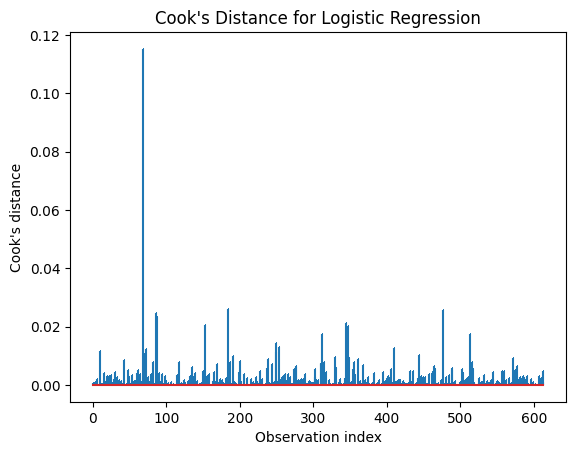

In [55]:
#Outliers-Influence Plot
influence = logit.get_influence()
cooks_d = influence.cooks_distance[0]

plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=',')
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.title("Cook's Distance for Logistic Regression")
plt.show()


Most observations have very low influence on the logistic regression model. The one line around 0.12 is far more influential than the rest, we can start by either removing the variable or examining it further